In [1]:
import pandas as pd
import numpy as np

## Reduce Memory Usage(Kaggle)

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [3]:
print('-' * 80)
print('articles')
customers = pd.read_csv("customers.csv",  delimiter=',')

print('-' * 80)
print('customer')
articles = import_data("articles.csv")

print('-' * 80)
print('transactions')
transactions = import_data("transactions.csv")

--------------------------------------------------------------------------------
articles
--------------------------------------------------------------------------------
customer
Memory usage of dataframe is 20.13 MB
Memory usage after optimization is: 7.25 MB
Decreased by 64.0%
--------------------------------------------------------------------------------
transactions
Memory usage of dataframe is 1212.63 MB
Memory usage after optimization is: 436.77 MB
Decreased by 64.0%


In [6]:
df_inner = pd.merge(transactions, articles, on='article_id', how='inner')
df_inner = pd.merge(df_inner, customers, on='customer_id', how='inner')

# Motto: Recommendations are Hook for a Customers' Attention.


The quality of the recommendation can be evaluated according to this method:
- First I assumed that recomendations are hook for a customers' attention.
- Customers click the recommended product but they end up scrolling that product type category.
- Therefore if customers last transaction's product type is in the recommended products' type, that is success.
    


## Split the Data According to Customers' Last Transaction and Previous Transactions

In [8]:
#find last transaction of every customer who made more than 1 transactions

all_customers = customers["customer_id"]

#sort transaction from recent date to old date

sorted_transactions= df_inner.sort_values(['t_dat'], ascending=False)


In [9]:
# record last transactions of every customers

last_transaction = {}
for i in all_customers:
    last_transaction[i] = list()
    

for i,v in  sorted_transactions.iterrows():
    
    if v["customer_id"] not in last_transaction.keys():
        pass
    else:
        a = last_transaction[v["customer_id"]]
        if len(a) < 3:
            last_transaction[v["customer_id"]].append([i,v["article_id"], v["product_type_name"],v["colour_group_name"]])

            
last_transaction

{'00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657': [[16673655,
   568601043,
   'Blazer',
   'Dark Green'],
  [16673644, 795440001, 'Vest top', 'Black'],
  [16673653, 887593002, 'Top', 'Off White']],
 '0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa': [[1781075,
   826211002,
   'Sweater',
   'Greenish Khaki'],
  [1781096, 811925005, 'Bikini top', 'Off White'],
  [1781095, 811835004, 'Bikini top', 'Light Yellow']],
 '000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318': [[17,
   794321007,
   'Jacket',
   'Greyish Beige'],
  [10, 851400006, 'Skirt', 'Beige'],
  [9, 858883002, 'Blouse', 'Pink']],
 '00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e': [[30678398,
   742079001,
   'Bra',
   'Black'],
  [30678397, 732413001, 'Bra', 'Black']],
 '00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a': [[12589246,
   896152002,
   'T-shirt',
   'Black'],
  [12589245, 791587015, 'T-shirt', 'Green'],
  [12589244, 927530004

## Strategy 1: Recommend the Populer Products of Last Transactioned CATEGORY

In [10]:
#find 5 product from each product type 
product_types = np.array(articles.groupby(["product_type_name"]).count().index)

# generate a hash table that store the each product's type
type_of = {}
for i,v in articles.iterrows():
    if v["article_id"] not in type_of.keys():
        type_of[v["article_id"]]= v["product_type_name"]
    else:
        pass


# generate a hash table that store the 5 populer item from each product's type
populer_product = {}
for i in product_types:
    populer_product[i] = list()
    

most_saled_articles = np.array(sorted_transactions.groupby(["article_id"]).count().sort_values(['t_dat'], ascending=False).index)
    
for product in  most_saled_articles:
    
    if type_of[product] not in populer_product.keys():
        pass
    else:
        a = populer_product[type_of[product]]
        if len(a) < 5:
            populer_product[type_of[product]].append(product)

populer_product




{'Accessories set': [858306003, 755356001, 858306006, 858306002, 858306005],
 'Alice band': [563993001, 335991001, 867257002, 696625001, 898196001],
 'Baby Bib': [757884002, 757884010, 757884012],
 'Backpack': [682238003, 851124001, 682238013, 682238030, 736631005],
 'Bag': [639448001, 682236001, 552716001, 647982001, 701738003],
 'Ballerinas': [349301001, 469039019, 349301025, 586955001, 581363001],
 'Beanie': [732409003, 682261004, 730901001, 695803011, 732409036],
 'Belt': [673396002, 759465001, 179950001, 664405002, 516859008],
 'Bikini top': [590928001, 684209004, 684209013, 699080001, 689109001],
 'Blanket': [615576001],
 'Blazer': [568601006, 568601007, 781613006, 636455003, 827635001],
 'Blouse': [695632002, 695632001, 697054014, 697054003, 688873002],
 'Bodysuit': [733097001, 733097008, 857880001, 852775002, 852775004],
 'Bootie': [645486001, 645486002, 672904001, 770237001, 783652001],
 'Boots': [502224001, 623115001, 709138001, 622955001, 682509001],
 'Bra': [723469001, 5647

## Strategy 2: Recommend the populer products of last transactioned COLOR

In [11]:
#find 5 most populer product from each product color 
product_colors = np.array(articles.groupby(["colour_group_name"]).count().index)

# generate a hash table that store the each product's color
color_of = {}
for i,v in articles.iterrows():
    if v["article_id"] not in color_of.keys():
        color_of[v["article_id"]]= v["colour_group_name"]
    else:
        pass


# generate a hash table that store the 5 populer item from each product's color
populer_product_color = {}
for i in product_colors:
    populer_product_color[i] = list()
    

most_saled_articles = np.array(sorted_transactions.groupby(["article_id"]).count().sort_values(['t_dat'], ascending=False).index)
    
for product in  most_saled_articles:
    
    if color_of[product] not in populer_product_color.keys():
        pass
    else:
        a = populer_product_color[color_of[product]]
        if len(a) < 5:
            populer_product_color[color_of[product]].append(product)


populer_product_color


{'Beige': [689109001, 806388003, 692930001, 806388005, 715624008],
 'Black': [706016001, 372860001, 610776002, 759871002, 464297007],
 'Blue': [448509014, 562245018, 741356002, 714790020, 573085004],
 'Bronze/Copper': [594978004, 805308003, 369796032, 774107003, 489435011],
 'Dark Beige': [739974006, 811198002, 762205003, 660599014, 673677011],
 'Dark Blue': [706016003, 706016006, 568601007, 399223033, 554450036],
 'Dark Green': [688537011, 684209013, 599580055, 689109003, 692930003],
 'Dark Grey': [706016015, 554450027, 803757004, 562245062, 756633003],
 'Dark Orange': [733027005, 832331003, 781613002, 740943001, 832330003],
 'Dark Pink': [212629048, 585130004, 746775004, 585158003, 677930006],
 'Dark Purple': [586307004, 630116017, 879294004, 633377008, 855080009],
 'Dark Red': [736530007, 611415005, 736531006, 684340002, 684341002],
 'Dark Turquoise': [763270005, 688873005, 770315007, 656719003, 812807002],
 'Dark Yellow': [751941002, 717490015, 669882005, 695632042, 861767002],
 'G

# Performance of Recommended Strategies

In [12]:
#recommend the customer who have more than 2 transaction , the populer products of the last transaction product's type
#recommend the customer who have more than 2 transaction, the populer products of the last transaction product's color

#split the customer last transaction and the previous transaction.
very_last_transacted_product_type = {}
second_last_transacted_product_type = {}
very_last_transacted_product_color = {}
second_last_transacted_product_color = {}
recommended_product_from_type = {}
recommended_product_from_color = {}
#if last transaction type is same with second last transaction type or color, it is success otherwise not
count1 = 0
count2 = 0
cumulative = 0
count3 = 0
total = 0

for cust in last_transaction.keys():
    if len(last_transaction[cust]) > 1:
        very_last_transacted_product_type[cust] = last_transaction[cust][0][2]
        second_last_transacted_product_type[cust] = last_transaction[cust][1][2]
        very_last_transacted_product_color[cust] = last_transaction[cust][0][3]
        second_last_transacted_product_color[cust] = last_transaction[cust][1][3]
        recommended_product_from_type[cust] = populer_product[last_transaction[cust][0][2]]
        recommended_product_from_color[cust] = populer_product_color[last_transaction[cust][0][3]]
        
        if (last_transaction[cust][0][2] == last_transaction[cust][1][2]):
            count1 += 1
        if (last_transaction[cust][0][3] == last_transaction[cust][1][3]):
            count2 += 1
        if (last_transaction[cust][0][3] == "Black") or (last_transaction[cust][0][2] == last_transaction[cust][1][2]) or (last_transaction[cust][0][3] == last_transaction[cust][1][3]) :
            cumulative += 1
        if (last_transaction[cust][0][3] == "Black"):
            count3 += 1
        total += 1
    else:
        pass

performance1 = count1 / total
performance2 = count2 / total
performance3 = count3 / total
performanceC = cumulative / total   

In [19]:
print("performance1 : ", performance1)
print("performance2 : ", performance2)
print("performance3 : ", performance3)
print("performanceC : ", performanceC)

performance1 :  0.3341582931619064
performance2 :  0.30951837350205197
performance3 :  0.3525890765677013
performanceC :  0.6253149458833395


## Strategy 3: Recommend the Populer Products of BLACK COLOR

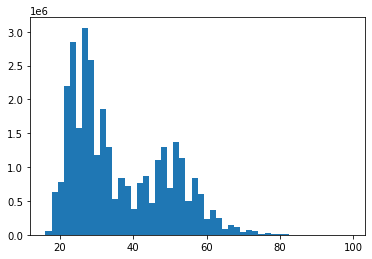

In [14]:
import matplotlib.pyplot as plt
plt.hist(df_inner["age"], bins = 50)
plt.show()

In [15]:
df_inner[(df_inner["age"] < 30) & (df_inner["age"] > 20)].groupby(["colour_group_name"]).count().sort_values(['t_dat'], ascending=False).head(5)

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,club_member_status,fashion_news_frequency,age
colour_group_name,,,,,,,,,,,,,,,,,,,,,
Black,4420096,4420096,4420096,4420096,4420096,4420096,4420096,4420096,4420096,4420096,...,4420096,4420096,4420096,4420096,4420096,4420096,4399262,4413635,4404106,4420096
White,1309086,1309086,1309086,1309086,1309086,1309086,1309086,1309086,1309086,1309086,...,1309086,1309086,1309086,1309086,1309086,1309086,1305733,1307199,1304926,1309086
Dark Blue,692916,692916,692916,692916,692916,692916,692916,692916,692916,692916,...,692916,692916,692916,692916,692916,692916,688258,692019,690149,692916
Light Beige,486698,486698,486698,486698,486698,486698,486698,486698,486698,486698,...,486698,486698,486698,486698,486698,486698,486123,486037,485186,486698
Blue,410073,410073,410073,410073,410073,410073,410073,410073,410073,410073,...,410073,410073,410073,410073,410073,410073,409923,409492,408796,410073


In [16]:
df_inner[(df_inner["age"] < 40) & (df_inner["age"] > 30)].groupby(["colour_group_name"]).count().sort_values(['t_dat'], ascending=False).head(5)

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,club_member_status,fashion_news_frequency,age
colour_group_name,,,,,,,,,,,,,,,,,,,,,
Black,1800162,1800162,1800162,1800162,1800162,1800162,1800162,1800162,1800162,1800162,...,1800162,1800162,1800162,1800162,1800162,1800162,1791121,1797005,1792306,1800162
White,508790,508790,508790,508790,508790,508790,508790,508790,508790,508790,...,508790,508790,508790,508790,508790,508790,507010,507886,506648,508790
Dark Blue,387651,387651,387651,387651,387651,387651,387651,387651,387651,387651,...,387651,387651,387651,387651,387651,387651,385909,386804,385702,387651
Light Beige,206763,206763,206763,206763,206763,206763,206763,206763,206763,206763,...,206763,206763,206763,206763,206763,206763,206360,206376,206085,206763
Blue,169591,169591,169591,169591,169591,169591,169591,169591,169591,169591,...,169591,169591,169591,169591,169591,169591,169514,169249,168969,169591


In [17]:
df_inner[(df_inner["age"] < 50) & (df_inner["age"] > 40)].groupby(["colour_group_name"]).count().sort_values(['t_dat'], ascending=False).head(5)

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,club_member_status,fashion_news_frequency,age
colour_group_name,,,,,,,,,,,,,,,,,,,,,
Black,1570199,1570199,1570199,1570199,1570199,1570199,1570199,1570199,1570199,1570199,...,1570199,1570199,1570199,1570199,1570199,1570199,1563136,1568067,1563365,1570199
White,476944,476944,476944,476944,476944,476944,476944,476944,476944,476944,...,476944,476944,476944,476944,476944,476944,475682,476404,474996,476944
Dark Blue,378297,378297,378297,378297,378297,378297,378297,378297,378297,378297,...,378297,378297,378297,378297,378297,378297,376603,377516,376633,378297
Blue,171023,171023,171023,171023,171023,171023,171023,171023,171023,171023,...,171023,171023,171023,171023,171023,171023,170940,170695,170378,171023
Light Beige,155008,155008,155008,155008,155008,155008,155008,155008,155008,155008,...,155008,155008,155008,155008,155008,155008,154816,154886,154411,155008


In [18]:
performance3 

0.3525890765677013